### Procesamiento de los datos

In [2]:
import requests
import time
import pprint
import pickle
import numpy as np
import json
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import xml.etree.ElementTree as ET
import re
from unicodedata import normalize
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pandas_summary import DataFrameSummary
%matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

#AL EJECUTAR ESTE SCRIPT ACTUALIZAMOS LAS VIVIENDAS QUE TENEMOS DISPONIBLES PARA EL MODELO
#lA SIGUIENTE TABLA ES LA TABLA FINAL QUE PROVIENE DEL PROYECTO Proyecto_datos_finales de SAS
data_tablin = pd.read_csv(r'C:\Users\Marta\Scripts - Presentación\DATOS_FINAL.csv', 
                   sep=';', engine="python", encoding="latin1")

data_tablin= data_tablin.loc[:,['MATRICULA','FCHTASAC','IMPTOTAL', 'SUPADAPT']]

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
def troceador_calles_api(street):
    words_street = []
    words_in_street = street.split(' ')
    for word in words_in_street:
        words = word.split(',')
        for w in words:
            if '/' in w:
                words.extend(w.split('/'))
        for w in words:
            if len(w) > 2 and w.upper() != 'DEL':
                words_street.append(w)
    return words_street
          
def comparador(streets_api, street_to_find):
    words_street_to_find = troceador_calles_api(street_to_find)
    streets = []
    for street in streets_api:
        words_street_api = troceador_calles_api(street)
        coincidences = 0
        for w1 in words_street_api:
            w1 = normalizador(w1)
            len_w1 = len(w1)
            coincidences_words = 0
            for w2 in words_street_to_find:
                w2 = normalizador(w2)
                if len_w1-1 < len(w2) < len_w1+1:
                    if w2 in w1:
                        coincidences_words += 1
            coincidences += coincidences_words
        if coincidences == len(words_street_to_find) and coincidences != 0:
            streets.append(street)
        elif coincidences >= max(int((len(words_street_api)+1)/2), int((len(words_street_to_find)+1)/2)):
            streets.append(street)
    
    if len(streets)==1:
        return streets[0]
    else:
        if len(set(streets))==1:
            return streets[0]
        else:
            for street in streets:
                if normalizador(street) in normalizador(street_to_find):
                    return street
            return False
        
def normalizador(string):
    string = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", str(string)), 0, re.I
    )
    string = string.lower()
    return normalize( 'NFC', string)

def parseo_fecha_cuatrimeste(row):
    if row[1] == 'Primero':
        date = '01/01/'
    elif row[1] == 'Segundo':
        date = '01/04/'
    elif row[1] == 'Tercero':
        date = '01/07/'
    elif row[1] == 'Cuarto':
        date = '01/10/'
    return date+str(row[0])

In [4]:
data_tablin = data_tablin[data_tablin['FCHTASAC'].notnull()]
data_tablin.loc[:,'DIA'] = data_tablin['FCHTASAC'].apply(lambda s: s[:2])
data_tablin.loc[:,'MES'] = data_tablin['FCHTASAC'].apply(lambda s: s[2:5])
data_tablin.loc[:,'AÑO'] = data_tablin['FCHTASAC'].apply(lambda s: int(s[5:9]))
dict_cuatri = {'NOV':'Cuarto', 'SEP':'Tercero', 'OCT':'Cuarto', 'DEC':'Cuarto', 'MAR':'Primero', 'JAN':'Primero', 'MAY':'Segundo', 'FEB':'Primero', 'APR':'Segundo', 'JUN':'Segundo', 'JUL':'Tercero', 'AUG':'Tercero'}
data_tablin['CUATRIMESTRE'] = data_tablin['MES'].map(dict_cuatri)
data_tablin = data_tablin[(data_tablin['AÑO']>1994)&(data_tablin['AÑO']<2019)]

data_tablin['Fecha'] = data_tablin.loc[:,['AÑO', 'CUATRIMESTRE']].apply(parseo_fecha_cuatrimeste,  axis=1)

columns_to_del = ['DIA','MES','AÑO', 'CUATRIMESTRE','FCHTASAC']
for col in columns_to_del:
    del data_tablin[col]

In [5]:
fechas = list(data_tablin.Fecha.drop_duplicates())
dictionary_dates_date_to_num = {}
dictionary_dates_num_to_date = {}
for date_iter in range(len(fechas)):
    dictionary_dates_date_to_num[fechas[date_iter]] = date_iter
    dictionary_dates_num_to_date[date_iter] = fechas[date_iter]

dictionary_dates_num_to_date[56] = '01/01/2019'
dictionary_dates_num_to_date[57] = '01/04/2019'
dictionary_dates_num_to_date[58] = '01/07/2019'
dictionary_dates_num_to_date[59] = '01/10/2019'
dictionary_dates_num_to_date[60] = '01/01/2020'
dictionary_dates_num_to_date[61] = '01/04/2020'
dictionary_dates_num_to_date[62] = '01/07/2020'
dictionary_dates_num_to_date[63] = '01/10/2020'

In [6]:
data_tablin = data_tablin[data_tablin['SUPADAPT']>1]

In [7]:
dates = {}
iter_ = 0
for year in range(2005,2019):
    for month in ['01','04','07','10']:
        for day in ['01']:
            dates[day+'/'+month+'/'+str(year)] = iter_
            iter_ += 1

In [8]:
data_tablin['Fecha_num'] = data_tablin['Fecha'].map(dates)
data_pred_index = data_tablin.loc[:,['MATRICULA','Fecha_num']].groupby('MATRICULA').idxmax()   #agrupamos por matrícula (la fecha más reciente)
tablin = data_tablin.loc[data_pred_index['Fecha_num']]   #filtramos y nos quedamos sin duplicados de la misma vivienda con distinta fecha 
data=tablin.drop(['MATRICULA','Fecha_num'], axis=1)

In [9]:
data['Preciom2'] = data['IMPTOTAL']/data['SUPADAPT']  #cálculo del precio del m2
data= data.loc[:,['Fecha','Preciom2']]
data['Precio_medio'] = data.groupby(['Fecha'])['Preciom2'].transform('mean')   #media precio m2 por fecha (toda España)

In [10]:
data = data.sort_values('Fecha')
data.Fecha = pd.to_datetime(data.Fecha, format='%d/%m/%Y')
data.index = data.Fecha

data= data.loc[:,['Precio_medio']]
#data= data[np.abs(data['Precio_medio']-data['Precio_medio'].mean()) <= (3*data['Precio_medio'].std())] 

In [11]:
data = data.drop_duplicates()
data= data.dropna() 
data= data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [12]:
data = data.sort_values('Fecha')

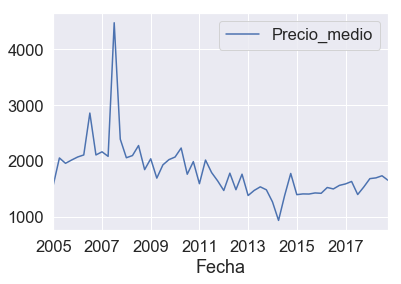

In [13]:
data.plot()

In [14]:
result = adfuller(data['Precio_medio'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
#The Augmented Dickey-Fuller Test says data is stationary so an ARIMA would work

ADF Statistic: -1.301443845380198
p-value: 0.6285114940424725
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


In [15]:
data.shape

(56, 1)

In [16]:
stepwise_model = auto_arima(data, start_p=2, start_q=2,
                           max_p=5, max_q=5, m=2, maxiter=30,
                           start_P=1, seasonal=True,
                           d=1, D=1,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 2); AIC=806.692, BIC=818.513, Fit time=0.231 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 2); AIC=852.463, BIC=856.404, Fit time=0.000 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 2); AIC=816.125, BIC=824.006, Fit time=0.157 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 2); AIC=805.364, BIC=813.245, Fit time=0.166 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 2); AIC=806.636, BIC=816.487, Fit time=0.189 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 2); AIC=826.606, BIC=832.516, Fit time=0.055 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 2); AIC=812.085, BIC=821.937, Fit time=0.214 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 2); AIC=813.638, BIC=825.460, Fit time=0.278 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 2); AIC=818.271, BIC=828.122, Fit time=0.173 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 2);

In [17]:
model_fit= stepwise_model.fit(data)

In [18]:
stepwise_model.resid()

array([ 1577.70111059,   553.2540949 ,  -820.40253676,  -486.66302031,
        -243.67680715,  -263.18406667,   565.97984405,  -595.37658627,
        -541.30620052,  -324.14560952,  2007.59502026,  -736.29436977,
       -1448.06414904,  -458.84025056,  -568.78376334,  -439.09910602,
        -493.93866316,  -296.51242285,  -321.00081556,   254.39186275,
        -115.26916283,   395.19006713,  -491.7610437 ,   135.89095079,
        -491.52813972,   270.32637958,  -147.85102001,  -144.37713305,
        -337.73902772,   189.6740461 ,  -198.81299359,   200.28338695,
        -233.77066939,   -52.23505025,    84.11566075,    11.5412451 ,
        -164.82015839,  -433.71051428,   208.14032697,   593.25357201,
          36.64679865,    37.76075396,    74.25648005,    69.79124224,
          87.24797071,   161.93950632,   128.07686244,   138.55160245,
         163.35107336,   138.00596744,  -104.51186231,    40.49768127,
         236.38265582,   144.01788689,   171.93708955,     6.72791936])

In [19]:
arima_residuals = pd.DataFrame(list(stepwise_model.resid()), index = data.index, columns=['Residuals'])
#el modelo arima solo representa los valores que ha predicho
#si queremos representarlos para poder comparar los resultados del modelo con la realidad, calculamos lo siguiente
data_residuals = pd.concat([data.iloc[1:], arima_residuals.iloc[1:]], axis=1, sort=True)
data_residuals['Predicts'] = data_residuals.loc[:, ['Precio_medio', 'Residuals']].apply(lambda s: s[0]+s[1], axis=1)
del data_residuals['Residuals']
future_forecast = stepwise_model.predict(n_periods=8)   #predicción arima con menor AIC (8 trimestres a futuro)
future_forecast = pd.DataFrame(future_forecast, index = pd.to_datetime(['01/01/2019', '01/04/2019', '01/07/2019',
                                                                        '01/10/2019', '01/01/2020', '01/04/2020',
                                                                        '01/07/2020', '01/10/2020'], format='%d/%m/%Y'),columns=['Predicts'])
data_residuals = data_residuals.append(future_forecast)

a, conf_int_05 = stepwise_model.predict(n_periods=8, return_conf_int=True, alpha=0.5)
a, conf_int_95 = stepwise_model.predict(n_periods=8, return_conf_int=True, alpha=0.05)  #calculamos el intervalo de confianza del 95%

plt.rcParams.update({'font.size': 16}) 

In [20]:
data_residuals.columns=['Precio_medio', 'BS_PREU']

In [21]:
actual= data_residuals['Precio_medio']
forecast= data_residuals['BS_PREU']

data_residuals['Error_MAPE']= round(np.abs(forecast - actual)/np.abs(actual),2)*100

data_residuals['Error_RMSE']=round(((forecast - actual)**2)**.5)  # RMSE

In [24]:
data_residuals['index']= data_residuals.index

In [27]:
data_residuals= data_residuals.loc[:,['index', 'Precio_medio','BS_PREU','Error_MAPE','Error_RMSE']]

In [47]:
data_residuals['index']=data_residuals['index'].dt.tz_localize(None)

In [50]:
writer= pd.ExcelWriter(r'C:\Users\Marta\Desktop\Rotación 2 SBD\BackUp_Proyecto\Python Scripts\resultados_ARIMA_excel.xlsx', date_format='yyyy-mm-dd')  
data_residuals.to_excel(writer)


In [22]:
del data_residuals['Error_MAPE']
del data_residuals['Error_RMSE']
data_residuals.columns=['Precio_medio', 'Predicts']

In [23]:
tablin= tablin.dropna()
tablin= tablin[~tablin.isin([np.nan, np.inf, -np.inf]).any(1)]
fechas = list(tablin.Fecha.drop_duplicates())

In [24]:
dictionary_dates_date_to_num = {}
dictionary_dates_num_to_date = {}
for date_iter in range(len(fechas)):
    dictionary_dates_date_to_num[fechas[date_iter]] = date_iter
    dictionary_dates_num_to_date[date_iter] = fechas[date_iter]
dictionary_dates_num_to_date[56] = '01/01/2019'
dictionary_dates_num_to_date[57] = '01/04/2019'
dictionary_dates_num_to_date[58] = '01/07/2019'
dictionary_dates_num_to_date[59] = '01/10/2019'
dictionary_dates_num_to_date[60] = '01/01/2020'
dictionary_dates_num_to_date[61] = '01/04/2020'
dictionary_dates_num_to_date[62] = '01/07/2020'
dictionary_dates_num_to_date[63] = '01/10/2020'   #info de los siguientes 8 trimestres (tenemos que asignarlo ya que el modelo no acepta fechas como índice)
list_dates = pd.to_datetime( list(dictionary_dates_num_to_date.values()), format='%d/%m/%Y')[:-1]
list_dates= list_dates.sort_values()

In [25]:
dictionary_dates_date_to_num = {}
dictionary_dates_num_to_date = {}
for date_iter in range(len(fechas)):
    dictionary_dates_date_to_num[fechas[date_iter]] = date_iter
    dictionary_dates_num_to_date[date_iter] = fechas[date_iter]

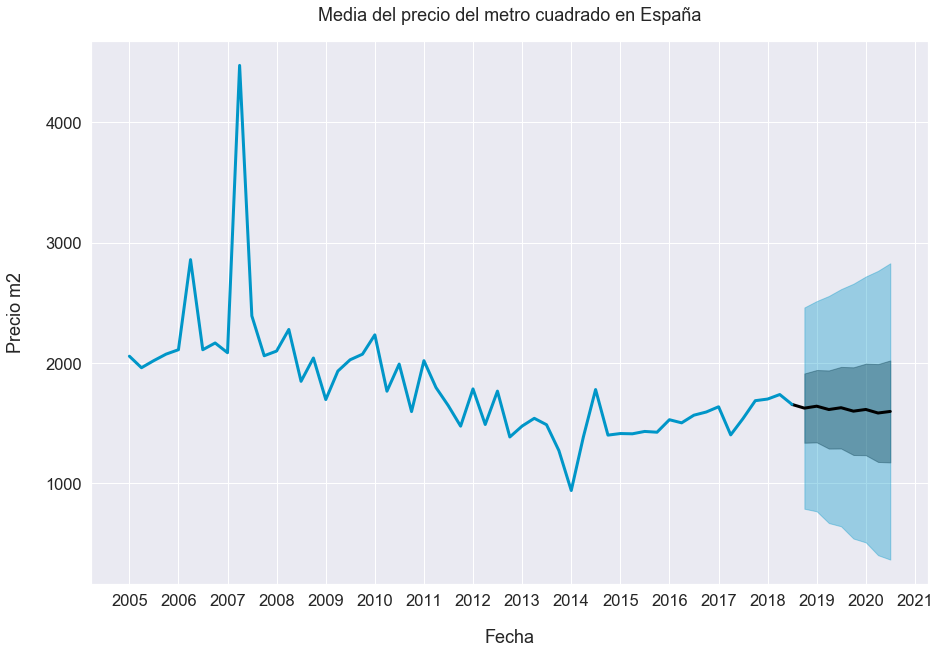

In [26]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,10))
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.plot(list_dates[54:], [data_residuals['Precio_medio'][-9]]+list(data_residuals['Predicts'][55:]), alpha=1, linewidth=3.00, color='black')  # Forecasts
ax.plot(list_dates, data_residuals['Precio_medio'], alpha=1, linewidth=3.00, color=(0, 150/255, 200/255))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


ax.fill_between(list_dates[-len(future_forecast):],
                 conf_int_05[:, 0], conf_int_05[:, 1],
                 alpha=0.35, color='black')
ax.fill_between(list_dates[-len(future_forecast):],
                 conf_int_95[:, 0], conf_int_95[:, 1],
                 alpha=0.35, color=(0, 150/255, 200/255))  #para hacer el intervalo de confianza
plt.title("Media del precio del metro cuadrado en España", pad=20)
plt.xlabel("Fecha", labelpad=20)
#plt.xticks(rotation='vertical')
plt.ylabel("Precio m2", labelpad=20)

plt.show()

In [27]:
data_residuals['index']= data_residuals.index
data_residuals['year']= data_residuals.index.year
data_residuals['month']= data_residuals.index.month
data_residuals['month'] = data_residuals['month'].map("{:02}".format)
data_residuals['date']= (data_residuals.year.astype(str) + data_residuals.month.astype(str))
data_residuals.index= data_residuals['date']
del data_residuals['year']
del data_residuals['month']
del data_residuals['date']
del data_residuals['index']


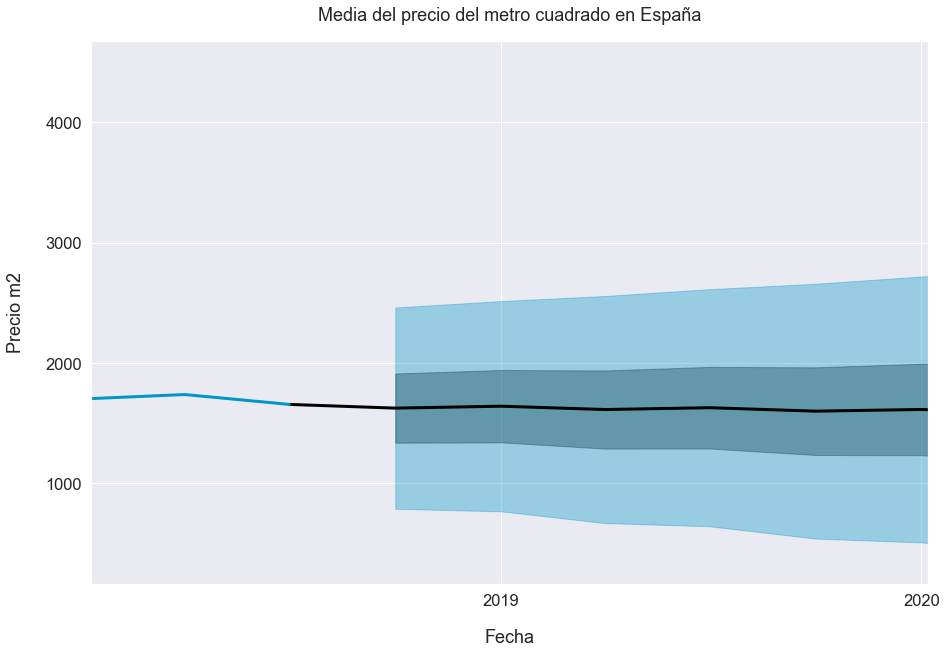

In [28]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,10))
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.plot(list_dates[54:], [data_residuals['Precio_medio'][-9]]+list(data_residuals['Predicts'][55:]), alpha=1, linewidth=3.00, color='black')  # Forecasts
ax.plot(list_dates, data_residuals['Precio_medio'], alpha=1, linewidth=3.00, color=(0, 150/255, 200/255))
ax.set_xlim(['01/10/2018', '01/07/2020'])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


ax.fill_between(list_dates[-len(future_forecast):],
                 conf_int_05[:, 0], conf_int_05[:, 1],
                 alpha=0.35, color='black')
ax.fill_between(list_dates[-len(future_forecast):],
                 conf_int_95[:, 0], conf_int_95[:, 1],
                 alpha=0.35, color=(0, 150/255, 200/255))  #para hacer el intervalo de confianza
plt.title("Media del precio del metro cuadrado en España", pad=20)
plt.xlabel("Fecha", labelpad=20)
#plt.xticks(rotation='vertical')
plt.ylabel("Precio m2", labelpad=20)

plt.show()